In [ ]:
import numpy as np
from scipy.stats import unitary_group, norm, entropy, ecdf, \
    kstest, cramervonmises, kstwo, chi2
from scipy.interpolate import interp1d
from scipy.special import binom, factorial
from functools import partial
from itertools import product

from seqModels import haarSeqModel
from circuit_MI import maxEntangle_state, seqModel_RA_vec, seqModel_RAmc
from QTM_jax import QTM, HaarSampleGeneration
from training_funcs import TrainingAvgState_t
from moments import framePot_batched
from information_measure import psiR_purity_vec, psiR_vNEntropy_vec

import jax
import jax.numpy as jnp

import qutip as qt
from qutip import Bloch

import time
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=25)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
# first order frame potential evolution
def FP1evo(dA, dB, ts):
    r = (dA**2 - 1)*dB/(dA**2 * dB**2 - 1)
    c = dA*(dB + 1) + (dA - 1)*(dA * dB - 1)*r**ts
    return c/(dA**2 * dB + 1)

def FP1evo_asymp(dA, dB, ts):
    return (1. + 1./dB)/dA + 1./float(dB)**ts

# holographic deep thermalization

In [ ]:
# haar unitary
n = 4
na = 1
T = 24

np.random.seed(42)
Us = unitary_group.rvs(dim=2**(n+na), size=T)

model = haarSeqModel(n, na, T)
model.setUnitary(Us)
states = model.dataGeneration_global(int(1e5))[-1]

path = f'data/seqRC/n{n}'
if not os.path.exists(path):
    os.makedirs(path)

fs = np.zeros(4)
for k in range(4):
    fs[k] = framePot_batched(states, K=k+1, batch_sizes=5000)
np.save(os.path.join(path, f'HaarUFP_n{n}na{na}T{T}.npy'), fs)

## average mutual information

In [ ]:
# Bell-input, exact calculation
num = 50

Na = 3
Nb = 2

probs = []
vnEntropy = []
purities = []
for t in range(1, 15//Nb+1):
    t0 = time.time()
    zs = np.array(list(product(range(2**Nb), repeat=t))).astype(np.int8)
    
    each_pr = jnp.zeros((num, 2**(Nb*t)))
    each_vn = jnp.zeros((num, 2**(Nb*t)))
    each_pu = jnp.zeros((num, 2**(Nb*t)))
    for j in range(num):
        np.random.seed(1+j)
        Us = unitary_group.rvs(dim=2**(Na+Nb), size=t).reshape(t, 2**(Na+Nb), 2**(Na+Nb))
        psi_RA = maxEntangle_state(Na).full().squeeze()
        
        res = seqModel_RA_vec(zs, Us, psi_RA, Na, Nb, t)
        
        each_pr = each_pr.at[j].set(jnp.product(res[0], axis=1))
        each_vn = each_vn.at[j].set(psiR_vNEntropy_vec(res[1], Na))
        each_pu = each_pu.at[j].set(psiR_purity_vec(res[1], Na))
    
    probs.append(each_pr)
    vnEntropy.append(each_vn)
    purities.append(each_pu)
    print(f'Nb={Nb}, step={t}, time={(time.time() - t0):.2f}')

path = f'data/info_flow/HDT/'
if not os.path.exists(path):
    os.makedirs(path)

np.savez(os.path.join(path, f'probs_Na{Na}Nb{Nb}_ex.npz'), *probs)
np.savez(os.path.join(path, f'vnEntropy_Na{Na}Nb{Nb}_ex.npz'), *vnEntropy)
np.savez(os.path.join(path, f'purity_Na{Na}Nb{Nb}_ex.npz'), *purities)

In [ ]:
num = 50
Na = 3
Nb = 2

mc_num = int(4e4)

vnEntropy = []
purities = []
for t in [20, 30, 40, 50, 60, 70]:
    t0 = time.time()
    
    each_vn = jnp.zeros((num, mc_num))
    each_pu = jnp.zeros((num, mc_num))
    for j in range(num):
        np.random.seed(1+j)
        Us = unitary_group.rvs(dim=2**(Na+Nb), size=t).reshape(t, 2**(Na+Nb), 2**(Na+Nb))
        psi_RA = maxEntangle_state(Na).full().squeeze()

        res = seqModel_RAmc(Us, psi_RA, Na, Nb, t, mc_num)
        
        each_vn = each_vn.at[j].set(psiR_vNEntropy_vec(res, Na))
        each_pu = each_pu.at[j].set(psiR_purity_vec(res, Na))
    
    vnEntropy.append(each_vn)
    purities.append(each_pu)
    print(f'Nb={Nb}, step={t}, time={(time.time() - t0):.2f}')

path = f'data/info_flow/HDT'
np.save(os.path.join(path, f'vnEntropy_Na{Na}Nb{Nb}_mc.npy'), np.stack(vnEntropy))
np.save(os.path.join(path, f'purity_Na{Na}Nb{Nb}_mc.npy'), np.stack(purities))

In [ ]:
# collect result
Na = 3
Nb = 2
t = [20, 30, 40, 50, 75, 100, 125, 150]
path = f'data/seqModel/Na{Na}/monitored/bell/'
prob = np.load(os.path.join(path, f'probs_Na{Na}Nb{Nb}_ex.npz'))
vnEn = np.load(os.path.join(path, f'vnEntropy_Na{Na}Nb{Nb}_ex.npz'))

avgMI = [2*Na*np.ones(20)]
for j in range(15):
    avgMI.append(2*(prob[f'arr_{j}']*vnEn[f'arr_{j}']).sum(1))

x = np.load(os.path.join(path, f'vnEntropy_Na{Na}Nb{Nb}_mc.npy'))
avgMI.extend(2*x.mean(2))

avgMI = np.stack(avgMI)

np.savez(f'data/info_flow/avgMI_Na{Na}Nb{Nb}', t=np.hstack((np.arange(16), t)), MI=avgMI)

# QML training

In [ ]:
# training 
n = 2
na = n
L = 2*(n + na)

# exponential interpolation
r = 0.22
T = 32
taus = (1 - np.exp(-r*np.arange(1, T+1)))/(1 - np.exp(-r*T))
s = f'r{r}'


Ndata = 400
epochs = 5001

path = f'data/training/avgState/n{n}/record/'
if not os.path.exists(path):
    os.makedirs(path)

inputs_0 = np.zeros((Ndata, 2**n), dtype=np.complex64)
inputs_0[:, 0] = 1.
psi0 = np.zeros(2**n, dtype=np.complex64)
psi0[0] = 1.
sigmaT = np.eye(2**n, dtype=np.complex64)/2**n

model = QTM(n, na, T, L)
for t in range(T):
    params_tot = np.zeros((T, 2*(n + na)*L))
    for tt in range(t):
        params = np.load(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{tt}_{s}.npy'))
        params_tot[tt] = params[-1]
    params_tot = jnp.array(params_tot)

    params_hist, loss_hist, states_hist = TrainingAvgState_t(model, t, taus[t], inputs_0, psi0, params_tot, epochs, 
                                                                dist_name='sup')

    np.save(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{t}_{s}.npy'), params_hist)
    np.save(os.path.join(path, f'HaarAvglosshist_n{n}na{na}T{T}L{L}_t{t}_{s}.npy'), loss_hist)
    np.save(os.path.join(path, f'HaarAvgstateshist_n{n}na{na}T{T}L{L}_t{t}_{s}.npy'), states_hist)
    print(f'Step {t} complete, tau={taus[t]:.5f}')

In [ ]:
# collect result
n = 4
na = 1
L = 2*(n + na)
Ndata = 400
epochs = 5001

T = 32

s = f'r0.22'

path = f'data/training/avgState/n{n}/'

params_hist = np.zeros((T, 51, 2*(n+na)*L))
params_tot = np.zeros((T, 2*(n+na)*L))
loss_hist = np.zeros((T, epochs))
states_hist = np.zeros((T, epochs//1000+1, Ndata, 2**n), dtype=np.complex64)
for t in range(T):
    each = np.load(os.path.join(path, f'record/HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{t}_{s}.npy'))
    params_hist[t] = each
    params_tot[t] = each[-1]
    loss_hist[t] = np.load(os.path.join(path, f'record/HaarAvglosshist_n{n}na{na}T{T}L{L}_t{t}_{s}.npy'))
    states_hist[t] = np.load(os.path.join(path, f'record/HaarAvgstateshist_n{n}na{na}T{T}L{L}_t{t}_{s}.npy'))
    
np.save(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_{s}.npy'), params_hist)
np.save(os.path.join(path, f'HaarAvgparams_n{n}na{na}T{T}L{L}_{s}.npy'), params_tot)
np.save(os.path.join(path, f'HaarAvglosshist_n{n}na{na}T{T}L{L}_{s}.npy'), loss_hist)
np.save(os.path.join(path, f'HaarAvgstateshist_n{n}na{na}T{T}L{L}_{s}.npy'), states_hist)

In [ ]:
# frame potential
n = 2
na = 1
L = n + na

T = 32

Ks = np.arange(1, 5)

s = f'r0.22' # exponential interpolation

path = f'data/training/avgState/n{n}'

params_tot = np.load(os.path.join(path, f'HaarAvgparams_n{n}na{na}T{T}L{L}{s}.npy'))
    
model = QTM(n, na, T, L)
states = model.dataGeneration(inputs_0, params_tot)[-1]

fs = np.zeros(4)
for k in range(4):
    fs[k] = framePot_batched(states, K=k+1, batch_sizes=5000)
np.save(os.path.join(path, f'states/HaarAvgFP_n{n}na{na}T{T}L{L}{s}.npy'), fs)

In [ ]:
n = 3
path = f'data/haarSample/n{n}'
if not os.path.exists(path):
    os.makedirs(path)

fs = np.zeros(4)
states = HaarSampleGeneration(int(1e5), n=n, seed=42)
for k in range(4):
    fs[k] = framePot_batched(states, K=k+1, batch_sizes=1000)
np.save(os.path.join(path, f'HaarSamplesFP_n{n}.npy'), fs)

# Result

## frame potential

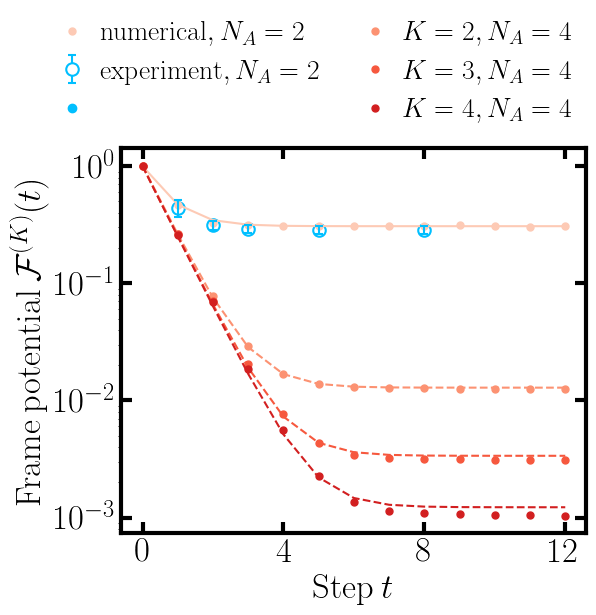

In [9]:
nB = 2
f1_num = np.load(f'data/seqRC/n2/HaarUFPtraj_n2na{nB}T{32}.npy')[0]
fs_num = np.load(f'data/seqRC/n{4}/HaarUFPtraj_n{4}na{nB}T{32}.npy')[1:]
f1_exp = np.load('data/experiment/purity/sherbrooke/purity_Na2Nb2L4.npy')

fig, ax0 = plt.subplots(figsize=(6, 5))
blues = plt.cm.Blues(np.linspace(0.2, 0.9, 5))
reds = plt.cm.Reds(np.linspace(0.2, 0.9, 5))

ax0.plot(np.mean(f1_num[:, :13], axis=0), 'o', markersize=5, c=reds[0], label=r'${\rm numerical},N_A=2$')
ax0.plot(FP1evo(4, 2**nB, np.arange(13)), c=reds[0])
ax0.errorbar([1, 2, 3, 5, 8], np.mean(f1_exp, axis=1), yerr=np.std(f1_exp, axis=1), fmt='o', c='deepskyblue',
    mfc='white', markersize=9, markeredgewidth=1.5, barsabove=True, capsize=3, label=r'${\rm experiment}, N_A=2$')
ax0.plot(0, 0, 'o', c='deepskyblue', label=r'$ $')
dA, dB = 16, 2**nB
for i in range(1, 4):
    ax0.plot(np.mean(fs_num[i-1, :, :13], axis=0), 'o', markersize=5, c=reds[i], label=fr'$K={i+1},N_A=4$')
    #ax0.plot(FPKevo_ph(16, 2**nB, i+1, np.arange(13)), '--', c=reds[i])
    Fk_theory = 1/dB**np.arange(13) + (1 + (2**(i+1)-1)/dB)/binom(i+1+dA-1, dA-1)
    ax0.plot(Fk_theory, '--', c=reds[i])
ax0.set_yscale('log')
handles, labels = ax0.get_legend_handles_labels()
order = [0, 5, 1, 2, 3, 4]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax0.legend(handles, labels, ncol=2, columnspacing=1, handletextpad=0, fontsize=20, 
    loc='lower left', bbox_to_anchor=(-0.22, 1), framealpha=0)
ax0.set_xlabel(r'${\rm Step}\:t$')
ax0.set_ylabel(r'${\rm Frame\:potential}\:\mathcal{F}^{(K)}(t)$')
ax0.set_xticks(np.arange(4)*4)
ax0.set_yticks([1e-3, 1e-2, 1e-1, 1])
ax0.tick_params(direction='in', length=8, width=3, top='on', right='on')

plt.savefig('figures/F.svg', bbox_inches='tight')
plt.show()
plt.close()

## PoP

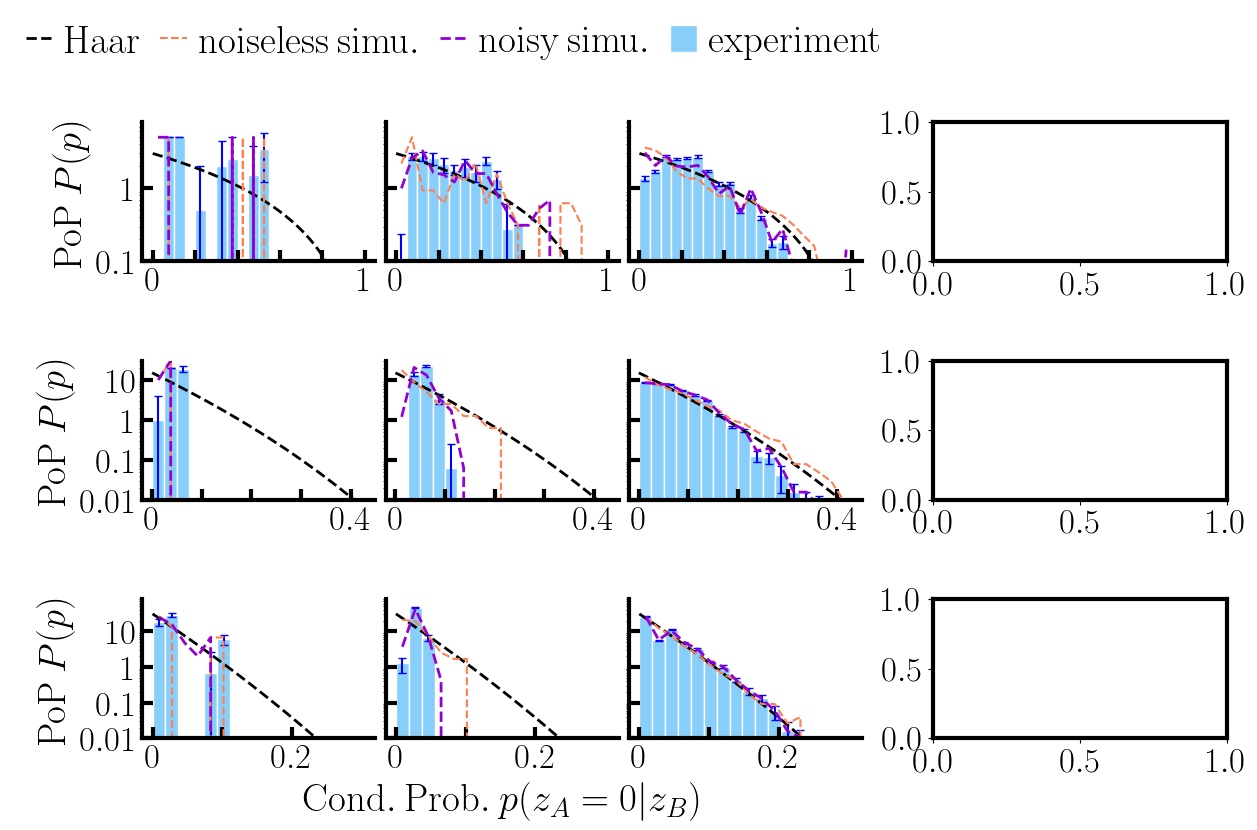

In [47]:
n_data, n_bath = 2, 2
condP_n2 = []
condP_simu_n2 = []
for step in [1, 3, 6]:
    condP_n2.append(np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}T{step}.npz'))
    condP_simu_n2.append(np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}T{step}.npz'))
condP_id_n2 = np.load(f'data/experiment/PoP/ideal/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}_merge.npz')

n_data, n_bath = 4, 2
condP_n4 = []
condP_simu_n4 = []
for step in [1, 3, 6]:
    condP_n4.append(np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}T{step}.npz'))
    condP_simu_n4.append(np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}T{step}.npz'))
condP_id_n4 = np.load(f'data/experiment/PoP/ideal/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}_merge.npz')

n_data, n_bath = 5, 3
condP_n5 = []
condP_simu_n5 = []
for step in [1, 2, 4]:
    condP_n5.append(np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}T{step}.npz'))
    condP_simu_n5.append(np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}T{step}.npz'))
condP_id_n5 = np.load(f'data/experiment/PoP/ideal/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data + n_bath}_merge.npz')

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(26, 18, figure=fig)
ax0 = plt.subplot(gs[:6, :4])
ax1 = plt.subplot(gs[:6, 4:8])
ax2 = plt.subplot(gs[:6, 8:12])
ax3 = plt.subplot(gs[:6, 13:])
ax4 = plt.subplot(gs[10:16, :4])
ax5 = plt.subplot(gs[10:16, 4:8])
ax6 = plt.subplot(gs[10:16, 8:12])
ax7 = plt.subplot(gs[10:16, 13:])
ax8 = plt.subplot(gs[20:, :4])
ax9 = plt.subplot(gs[20:, 4:8])
ax10 = plt.subplot(gs[20:, 8:12])
ax11 = plt.subplot(gs[20:, 13:])

axs = [[ax0, ax1, ax2, ax3], [ax4, ax5, ax6, ax7], [ax8, ax9, ax10, ax11]]

blues = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bins = [20, 40, 54]
qs = np.linspace(0, 1, 101)
for i in range(3):
    h, h_s = np.zeros((10, bins[0])), np.zeros((10, bins[0]))
    for j in range(10):
        h[j], b = np.histogram(condP_n2[i][f'arr_{j}'], bins=np.linspace(0, 1, bins[0]+1), density=True)
        h_s[j], _ = np.histogram(condP_simu_n2[i][f'arr_{j}'], bins=np.linspace(0, 1, bins[0]+1), density=True)
    # experiment
    axs[0][i].bar((b[1:]+b[:-1])/2, np.mean(h, axis=0), color='lightskyblue', width=b[1]-b[0], edgecolor='white',
        label=r'$\rm experiment$')
    axs[0][i].errorbar((b[1:]+b[:-1])/2, np.mean(h, axis=0), yerr=np.std(h, axis=0), color='b', 
        markersize=0, fmt='o', capsize=3)
    # porter-thomas
    axs[0][i].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='k', label=r'$\rm Haar$')
    # noiseless simulation
    h_i, _ = np.histogram(condP_id_n2[f'arr_{i}'], bins=np.linspace(0, 1, bins[0]+1), density=True)
    axs[0][i].plot((b[1:]+b[:-1])/2, h_i, '--', c='coral', lw=1.5, label=r'$\rm noiseless\:simu.$')
    # error model simulation
    axs[0][i].plot((b[1:]+b[:-1])/2, np.mean(h_s, axis=0), '--', c='darkviolet', lw=2, label=r'$\rm noisy\:simu.$')

    axs[0][i].set_yscale('log')
    axs[0][i].set_ylim(0.1, 8)
    axs[0][i].set_xticks(np.arange(6)*0.2)
    axs[0][i].set_xticklabels([r'$0$', '', '', '', '', r'$1$'])
    axs[0][i].set_yticks([0.1, 1])
    axs[0][i].set_yticklabels([r'$0.1$', r'$1$'])

    h, h_s = np.zeros((10, bins[1])), np.zeros((10, bins[1]))
    for j in range(10):
        h[j], b = np.histogram(condP_n4[i][f'arr_{j}'], bins=np.linspace(0, 1, bins[1]+1), density=True)
        h_s[j], _ = np.histogram(condP_simu_n4[i][f'arr_{j}'], bins=np.linspace(0, 1, bins[1]+1), density=True)
    # experiment
    axs[1][i].bar((b[1:]+b[:-1])/2, np.mean(h, axis=0), color='lightskyblue', width=b[1]-b[0], edgecolor='white',
        label=r'$\rm experiment$')
    axs[1][i].errorbar((b[1:]+b[:-1])/2, np.mean(h, axis=0), yerr=np.std(h, axis=0), color='b', 
        markersize=0, fmt='o', capsize=3)
    # porter-thomas
    axs[1][i].plot(qs, (2**4 - 1)*(1-qs)**(2**4-2), '--', lw=2, color='k', label=r'$\rm Haar$')
    # noiseless simulation
    h_i, _ = np.histogram(condP_id_n4[f'arr_{i}'], bins=np.linspace(0, 1, bins[1]+1), density=True)
    axs[1][i].plot((b[1:]+b[:-1])/2, h_i, '--', c='coral', lw=1.5, label=r'$\rm noiseless\:simu.$')
    # error model simulation
    axs[1][i].plot((b[1:]+b[:-1])/2, np.mean(h_s, axis=0), '--', c='darkviolet', lw=2, label=r'$\rm noisy\:simu.$')

    axs[1][i].set_yscale('log')
    axs[1][i].set_ylim(0.01, 30)
    axs[1][i].set_xlim(-0.02, 0.45)
    axs[1][i].set_xticks(np.arange(5)*0.1)
    axs[1][i].set_xticklabels([r'$0$', '', '', '', r'$0.4$'])
    axs[1][i].set_yticks([0.01, 0.1, 1, 10])
    axs[1][i].set_yticklabels([r'$0.01$', r'$0.1$', r'$1$', r'$10$'])

    h, h_s = np.zeros((10, bins[2])), np.zeros((10, bins[2]))
    for j in range(10):
        h[j], b = np.histogram(condP_n5[i][f'arr_{j}'], bins=np.linspace(0, 1, bins[2]+1), density=True)
        h_s[j], _ = np.histogram(condP_simu_n5[i][f'arr_{j}'], bins=np.linspace(0, 1, bins[2]+1), density=True)
    # experiment
    axs[2][i].bar((b[1:]+b[:-1])/2, np.mean(h, axis=0), color='lightskyblue', width=b[1]-b[0], edgecolor='white',
        label=r'$\rm experiment$')
    axs[2][i].errorbar((b[1:]+b[:-1])/2, np.mean(h, axis=0), yerr=np.std(h, axis=0), color='b', 
        markersize=0, fmt='o', capsize=3)
    # porter-thomas
    axs[2][i].plot(qs, (2**5 - 1)*(1-qs)**(2**5-2), '--', lw=2, color='k', label=r'$\rm Haar$')
    # noiseless simulation
    h_i, _ = np.histogram(condP_id_n5[f'arr_{i}'], bins=np.linspace(0, 1, bins[2]+1), density=True)
    axs[2][i].plot((b[1:]+b[:-1])/2, h_i, '--', c='coral', lw=1.5, label=r'$\rm noiseless\:simu.$')
    # error model simulation
    axs[2][i].plot((b[1:]+b[:-1])/2, np.mean(h_s, axis=0), '--', c='darkviolet', lw=2, label=r'$\rm noisy\:simu.$')
    
    axs[2][i].set_yscale('log')
    axs[2][i].set_ylim(0.01, 80)
    axs[2][i].set_xlim(-0.015, 0.32)
    axs[2][i].set_xticks(np.arange(3)*0.1)
    axs[2][i].set_xticklabels([r'$0$', '', r'$0.2$'])
    axs[2][i].set_yticks([0.01, 0.1, 1, 10])
    axs[2][i].set_yticklabels([r'$0.01$', r'$0.1$', r'$1$', r'$10$'])

# axs[0][-1].plot(qs, pt_cdf(qs, 2), '--', c='k')
# axs[1][-1].plot(qs, pt_cdf(qs, 4), '--', c='k')
# axs[2][-1].plot(qs, pt_cdf(qs, 5), '--', c='k')
axs[0][0].legend(ncol=4, columnspacing=0.5, loc='lower left', bbox_to_anchor=(-0.65, 1.2),
    handlelength=0.7, framealpha=0, handletextpad=0.3, fontsize=28)
# CDF or P-P plot
# x = np.linspace(0, 1, bins[0]+1)
# cdf_g = np.zeros((10, bins[0]+1))
# ks_p, cm_g = np.zeros(10), np.zeros(10)
# for j in range(10):
#     cdf_g[j] = gaussian_cdf(x, condP_n2[-1][f'arr_{j}'], 0.05)

#     ks_g = np.max(np.abs(cdf_g[j] - pt_cdf(x, 2)))
#     ks_p[j] = kstwo.sf(ks_g, len(x))
#     cm_g[j] = np.sum((cdf_g[j] - pt_cdf(x, 2))**2 * pt_density(x, 2)/sum(pt_density(x, 2)))
# print(f'N_A=2, KS p-value={ks_p}, CM T-value={cm_g}')
# axs[0][-1].plot(x, np.mean(cdf_g, axis=0), c='deepskyblue')

# x = np.linspace(0, 1, bins[1]+1)
# cdf_g = np.zeros((10, bins[1]+1))
# ks_p, cm_g = np.zeros(10), np.zeros(10)
# for j in range(10):
#     cdf_g[j] = gaussian_cdf(x, condP_n4[-1][f'arr_{j}'], 0.05)

#     ks_g = np.max(np.abs(cdf_g[j] - pt_cdf(x, 4)))
#     ks_p[j] = kstwo.sf(ks_g, len(x))
#     cm_g[j] = np.sum((cdf_g[j] - pt_cdf(x, 4))**2 * pt_density(x, 4)/sum(pt_density(x, 4)))
# print(f'N_A=4, KS p-value={ks_p}, {cm_g}, CM T-value={cm_g}')
# axs[1][-1].plot(x, np.mean(cdf_g, axis=0), c='deepskyblue')

# x = np.linspace(0, 1, bins[2]+1)
# cdf_g = np.zeros((10, bins[2]+1))
# ks_p, cm_g = np.zeros(10), np.zeros(10)
# for j in range(10):
#     cdf_g[j] = gaussian_cdf(x, condP_n5[-1][f'arr_{j}'], 0.05)

#     ks_g = np.max(np.abs(cdf_g[j] - pt_cdf(x, 5)))
#     ks_p[j] = kstwo.sf(ks_g, len(x))
#     cm_g[j] = np.sum((cdf_g[j] - pt_cdf(x, 5))**2 * pt_density(x, 5)/sum(pt_density(x, 5)))
# print(f'N_A=5, KS p-value={ks_p}, {cm_g}, CM T-value={cm_g}')
# axs[2][-1].plot(x, np.mean(cdf_g, axis=0), c='deepskyblue')

for i in range(3):
    axs[i][0].set_ylabel(r'${\rm PoP}\: P(p)$', fontsize=28)
#     axs[i][-1].set_ylabel(r'${\rm CDF}(p)$', fontsize=28)
#     axs[i][-1].tick_params(direction='in', length=8, width=3, top='on', right='on')
# axs[2][-1].set_xlabel(r'$p(z_A=0|z_B)$', fontsize=28)
# axs[0][-1].set_xlim(-0.08, 1.08)
# axs[1][-1].set_xlim(-0.03, 0.43)
# axs[1][-1].set_xticks([0, 0.4])
# axs[2][-1].set_xlim(-0.02, 0.32)
# axs[2][-1].set_xticks([0, 0.3])

for i in range(1, 3):
    for j in range(3):
        axs[j][i].set_yticklabels([])

for i in range(3):
    for j in range(3):
        axs[j][i].spines['right'].set_color('none')
        axs[j][i].spines['top'].set_color('none')
        axs[j][i].tick_params(direction='in', length=8, width=3)

fig.text(0.24, 0.02, r'${\rm Cond.\: Prob.}\: p(z_A=0|z_B)$', fontsize=28)

plt.savefig('figures/pop.svg', bbox_inches='tight')
plt.show()
plt.close()

## Q-size

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_6864\3991339091.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels([r'$K+\log_2(1/\epsilon)$', r'$N_A$', r'$KN_A+\log_2(1/\epsilon)$'],


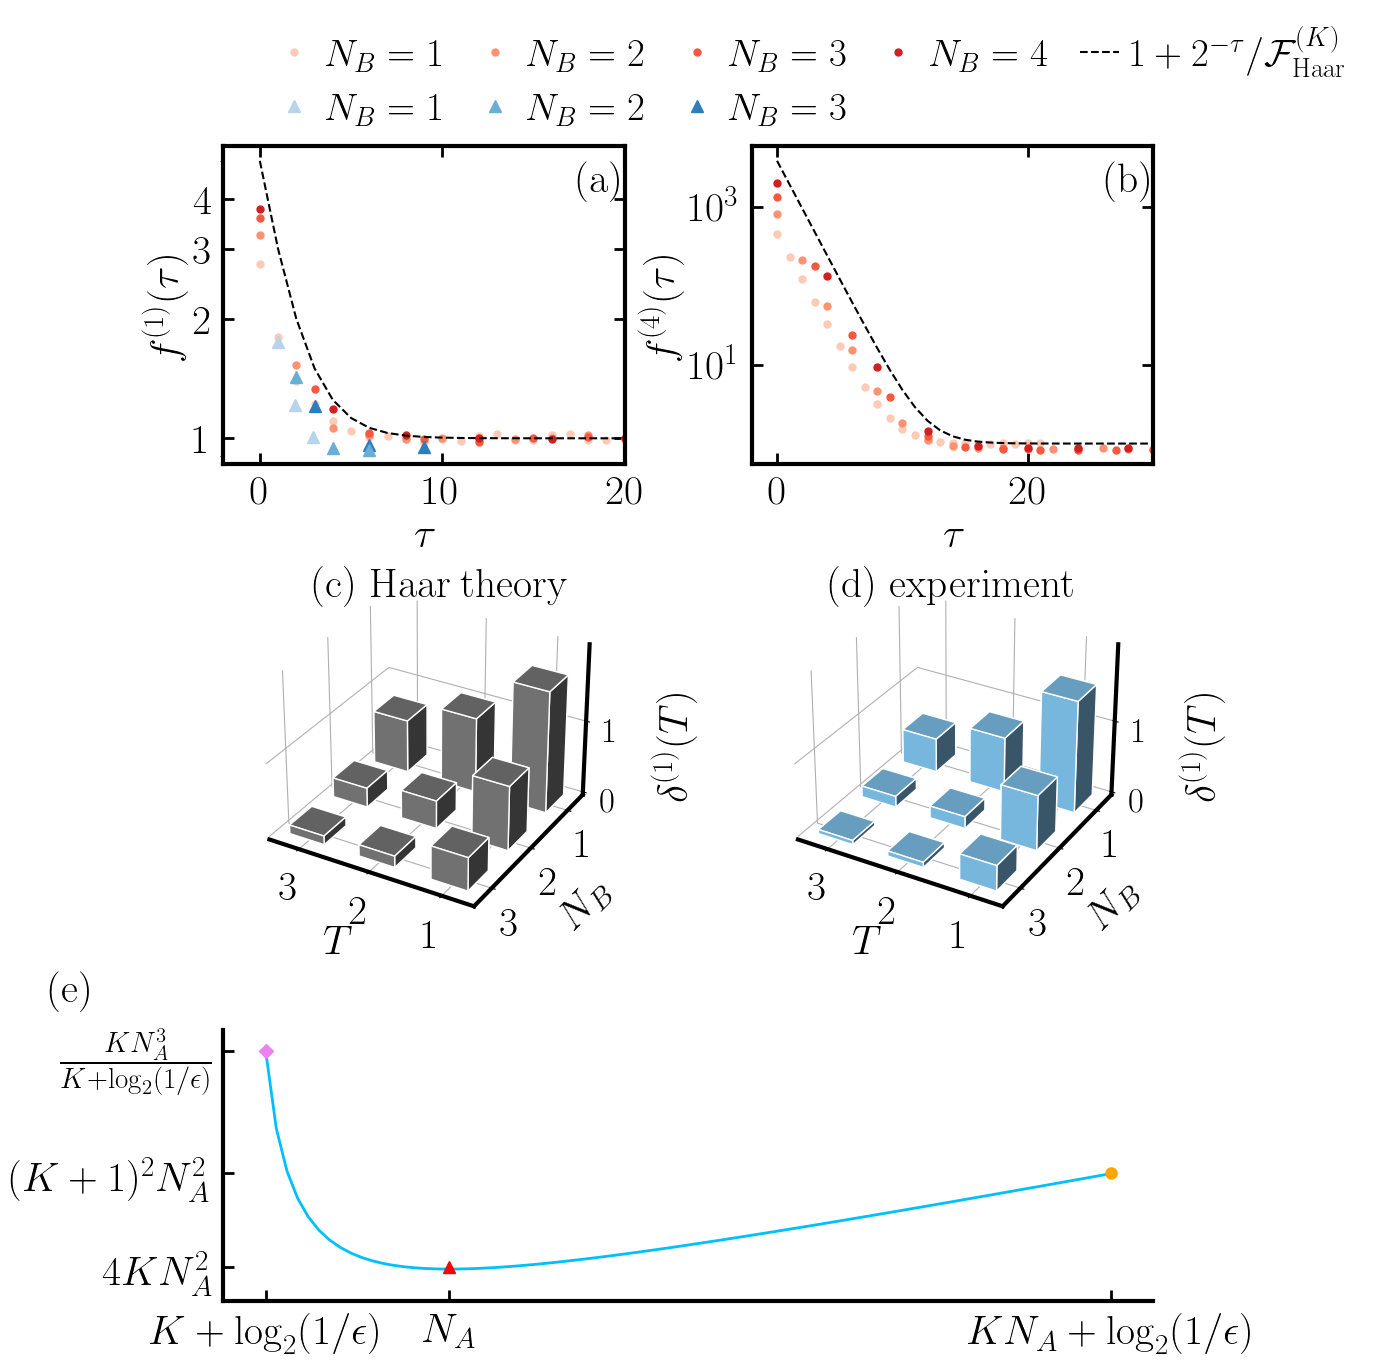

In [ ]:
nb1 = np.arange(14, 411, 5)
T1 = np.loadtxt('data/qVol/Ts_n100k4.csv')

nb = np.arange(1, 5)

fs_traj = np.zeros((4, 33))
fs_traj2 = np.zeros((4, 33))
for i in range(4):
    each = np.load(f'data/seqRC/n{2}/HaarUFPtraj_n{2}na{nb[i]}T{32}.npy')[0]
    fs_traj[i] = np.mean(each, axis=0)
    each = np.load(f'data/seqRC/n{4}/HaarUFPtraj_n{4}na{nb[i]}T{32}.npy')[-1]
    fs_traj2[i] = np.mean(each, axis=0)

f_theory = np.zeros((3, 3))
for Nb in range(1, 4):
    f_theory[Nb-1] = FP1evo(4, 2**Nb, np.arange(1, 4))

f_simu = np.load(f'data/experiment/purity/brisbane/Tradeoff_Brisbane.npy')

fig = plt.figure(figsize=(12, 15))
gs = GridSpec(25, 16, figure=fig)
ax0 = plt.subplot(gs[19:, :])
ax1 = plt.subplot(gs[:7, :7])
ax2 = plt.subplot(gs[:7, 9:])
ax3 = plt.subplot(gs[9:17, :7], projection="3d")
ax4 = plt.subplot(gs[9:17, 9:], projection="3d")
axs = [ax0, ax1, ax2, ax3, ax4]

blues = plt.cm.Blues(np.linspace(0.3, 0.9, 4))
reds = plt.cm.Reds(np.linspace(0.2, 0.9, 5))

ax0.plot(nb1, T1*(100 + nb1)**2, c='deepskyblue', lw=2)
ax0.plot(100, T1[17]*(100 + 100)**2, '^', markersize=8, c='r')
ax0.plot(14, T1[0]*(100 + 14)**2, 'D', markersize=7, c='violet')
ax0.plot(4*100 + 10, T1[-1]*(100 + 4*100 + 10)**2, 'o', markersize=8, c='orange')
ax0.set_yticks([T1[0]*(100 + 14)**2, T1[17]*(100 + 100)**2, T1[-1]*(100 + 4*100 + 10)**2])

ax0.spines['right'].set_color('none')
ax0.spines['top'].set_color('none')
ax0.set_xticklabels([r'$K+\log_2(1/\epsilon)$', r'$N_A$', r'$KN_A+\log_2(1/\epsilon)$'],
    fontsize=30)
ax0.set_yticklabels([r'$\frac{KN_A^3}{K + \log_2(1/\epsilon)}$', r'$4KN_A^2$', r'$(K+1)^2 N_A^2$'],
    fontsize=30)
ax0.tick_params(direction='in', length=8, width=2, pad=8)
ax0.set_xticks([14, 100, 410])
ax0.set_ylim(1.3e5, 4e5)

dA1 = 2**2
dA2 = 2**4
Fh = 1./binom(dA2 + 4-1, dA2-1)
for i in range(4):
    dB = 2**nb[i]
    # ax1.plot(np.log2((dA1**2 * dB**2 - 1)/(dA1**2 * dB - dB))*np.arange(22), 
    #     (dA1**2 * dB + 1)/(dA1*(dB+1)) * fs_traj[i, :22], 'o', markersize=5, c=reds[i], label=fr'$N_B={nb[i]}$')
    ax1.plot(nb[i]*np.arange(22), (dA1**2 * dB + 1)/(dA1*(dB+1)) * fs_traj[i, :22], 'o', 
             markersize=5, c=reds[i], label=fr'$N_B={nb[i]}$')
    # ax2.plot(np.log2((dA2**2 * dB**2 - 1)/(dA2**2 * dB))*np.arange(22), 
    #     fs_traj2[i, :22]/((1 + (2**4-1)/dB)*Fh), 'o', c=reds[i], markersize=5)
    ax2.plot(nb[i]*np.arange(22), fs_traj2[i, :22]/((1 + (2**4-1)/dB)*Fh), 'o', c=reds[i], markersize=5)

ax1.plot(np.arange(90), 1 + dA1 * 2.**(-np.arange(90)), '--', c='k', 
    label=r'$1+2^{-\tau}/\mathcal{F}_{\rm Haar}^{(K)}$')
ax2.plot(np.arange(90), 1 + (1./Fh)*2.**(-np.arange(90)), '--', c='k')

for i in range(1, 3):
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$\tau$', fontsize=30)
    axs[i].set_ylabel(r'$f^{(%d)}(\tau)$'%(3*(i-1)+1), fontsize=30)
    axs[i].tick_params(direction='in', length=8, width=2, pad=8, labelsize=30, right='on', top='on')
    axs[i].set_xlim(-2, 10+10*i)
ax1.set_yticks([1, 2, 3, 4])
ax1.set_yticklabels([fr'${x}$' for x in range(1, 5)], fontsize=30)


# theory
rows, cols = f_theory.shape
x, y = np.meshgrid(np.arange(cols, 0, -1), np.arange(rows, 0, -1))  # Create grid for bar positions
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)  # Base height (starts from 0)
heights = (4*f_theory-1).flatten()  # Flatten the 2D array for plotting

ax3.bar3d(x, y, z, dx=0.5, dy=0.5, dz=heights, color='gray', edgecolor='white')

# experiment
rows, cols = f_simu.shape
x, y = np.meshgrid(np.arange(cols, 0, -1), np.arange(rows, 0, -1))  # Create grid for bar positions
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)  # Base height (starts from 0)
heights = (4*f_simu-1).flatten()  # Flatten the 2D array for plotting

ax4.bar3d(x, y, z, dx=0.5, dy=0.5, dz=heights, color='lightskyblue', edgecolor='white')

for i in range(3, 5):
    axs[i].set_xlabel(r'$T$', labelpad=15, fontsize=30)
    axs[i].set_ylabel(r'$N_B$', labelpad=15, fontsize=30)
    #axs[i].set_zlabel(r'$\delta \mathcal{F}^{(1)}(T)$', labelpad=10)
    axs[i].set_xticks(np.arange(1, cols+1)+.25)
    axs[i].set_yticks(np.arange(1, rows+1)+.25)
    axs[i].set_zticks([0, 1])
    axs[i].set_zlim(0, 2)
    axs[i].set_xticklabels([fr'${round(cols+1.25-i)}$' for i in np.arange(1, cols+1)+.25],
                           fontsize=30)
    axs[i].set_yticklabels([fr'${round(rows+1.25-i)}$' for i in np.arange(1, rows+1)+.25],
                           fontsize=30)

    axs[i].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Set X-axis pane to transparent
    axs[i].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Set Y-axis pane to transparent
    axs[i].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
fig.text(0.48, 0.45, r'$\delta^{(1)}(T)$', rotation=90, fontsize=30)
fig.text(0.92, 0.45, r'$\delta^{(1)}(T)$', rotation=90, fontsize=30)

for i in range(3):
    dB = 2**(i+1)
    ax1.plot(np.log2((dA1**2 * dB**2-1)/(dA1**2*dB))*np.arange(1, 4), 
        (dA1**2 * dB + 1)/(dA1*(dB+1))*f_simu[i], '^', c=blues[i], markersize=8, zorder=5-i,
        label=fr'$N_B={i+1}$')

handles, labels = ax1.get_legend_handles_labels()
order = [0, 5, 1, 6, 2, 7, 3, 4]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax1.legend(handles, labels, ncol=5, columnspacing=0.8, loc='lower left', bbox_to_anchor=(0.04, 0.95), 
    framealpha=0, handletextpad=0.3, handlelength=1, fontsize=28)

fig.text(0.42, 0.85, r'$\rm (a)$', fontsize=30)
fig.text(0.86, 0.85, r'$\rm (b)$', fontsize=30)
fig.text(0.2, 0.58, r'$\rm (c)$' + ' ' + r'$\rm Haar\:theory$', fontsize=30)
fig.text(0.63, 0.58, r'$\rm (d)$' + ' ' + r'$\rm experiment$', fontsize=30)
fig.text(-0.02, 0.31, r'$\rm (e)$', fontsize=30)

plt.savefig('figures/qVol.svg', bbox_inches='tight')
plt.show()
plt.close()

## average mutual information

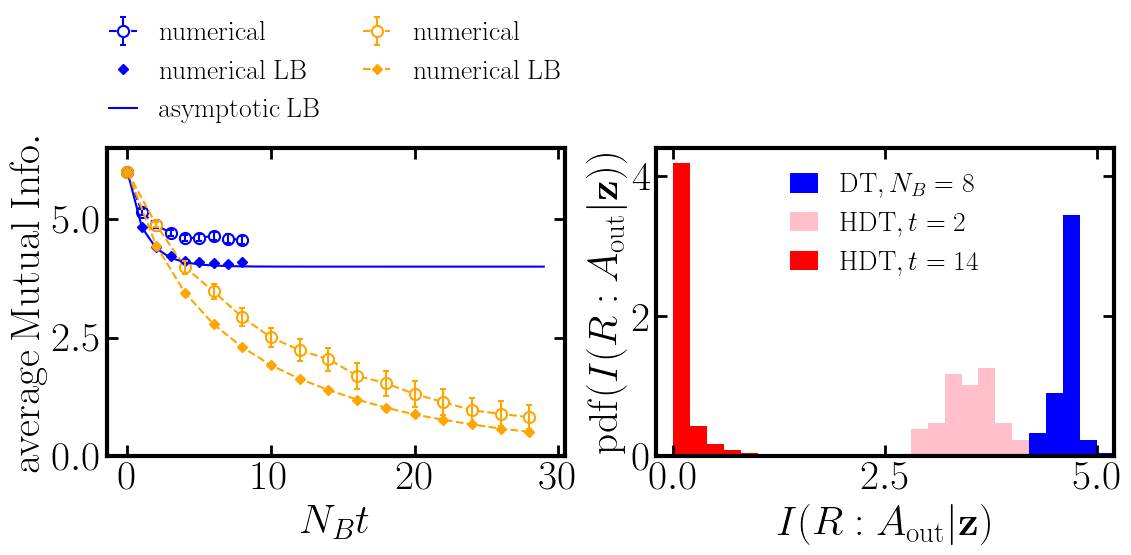

In [ ]:
idx = 25

avgS1 = np.load('data/info_flow/avgS1_Na3.npy')
S1 = np.load('data/info_flow/vnEntropy_Na3.npz')
S1std = [np.std(S1[f'arr_{j}'][idx]) for j in range(len(S1))]
S1worst = [2*np.max(S1[f'arr_{j}'][idx]) for j in range(len(S1))]
avgS2 = np.load('data/info_flow/avgS2_Na3.npy')

avgS1_ho = np.load('data/info_flow/avgS1_Na3Nb2.npy')
S1_ho1 = np.load('data/info_flow/vnEntropy_Na3Nb2_ex.npz')
S1_ho2 = np.load('data/info_flow/vnEntropy_Na3Nb2_mc.npy')
S1_ho = [S1_ho1[f'arr_{j}'] for j in range(len(S1_ho1))]
S1_ho.extend([S1_ho2[j] for j in range(len(S1_ho2))])
S1std_ho = [np.std(S1_ho[j][idx]) for j in range(len(S1_ho))]
S1_ho_worst = [2*np.max(S1_ho[j][idx]) for j in range(len(S1_ho))]
avgS2_ho = np.load('data/info_flow/avgS2_Na3Nb2.npy')


dA = 2**3
dB = 2.**np.arange(30)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
ax, ax2 = axs
ax.errorbar(np.arange(9), 2*avgS1[:, idx], yerr=np.hstack(([0], S1std)), fmt='o--', mfc='white', barsabove=True,
        capsize=2, markersize=8, markeredgewidth=1.5, c='b', label=r'$\rm numerical$')
#ax.plot(np.hstack((6, S1worst)), '^--', markersize=6, c='b', label=r'$\rm numerical\:worst\:case$')
ax.plot(2*avgS2.mean(1), 'D', markersize=5, c='b', label=r'$\rm numerical\:LB$')
ax.plot(-2*np.log2(2/dA * (1 - 1/(2*dB))), c='b', label=r'$\rm asymptotic\:LB$')

t_end = 15
ax.errorbar(2*np.arange(t_end), 2*avgS1_ho[:t_end, idx], yerr=np.hstack(([0], S1std_ho))[:t_end], fmt='o--', mfc='white', barsabove=True,
        capsize=2, markersize=8, markeredgewidth=1.5, c='orange', label=r'$\rm numerical$')
ax.plot(2*np.arange(t_end), 2*avgS2_ho[:t_end].mean(1), 'D--', markersize=5, c='orange',
        label=r'$\rm numerical\:LB$')
#ax.plot(2*np.arange(t_end), np.hstack((6, S1_ho_worst))[:t_end], '^--', markersize=6, c='orange', label=r'$\rm numerical\:worst\:case$')

handles, labels = ax.get_legend_handles_labels()
#print(labels)
label_idx = [3, 0, 1, 4, 2]
handles_re = [handles[i] for i in label_idx]
labels_re = [labels[i] for i in label_idx]
ax.legend(handles_re, labels_re, fontsize=20, handlelength=1, ncol=2, columnspacing=1.5, 
        loc='lower left', bbox_to_anchor=(-0.05, 1.), framealpha=0)
ax.set_ylabel(r'${\rm average\:Mutual\:Info.}$', fontsize=30)
ax.set_xlabel(r'$N_B t$', fontsize=30)
ax.set_ylim(0, 6.5)
ax.set_xticks(np.arange(4)*10)
ax.tick_params(direction='in', top='on', right='on', length=8, width=2, labelsize=30)

ax2.hist(2*S1['arr_7'][idx], bins=30, range=(0, 6), density=True, color='b', label=r'${\rm DT}, N_B = 8$')
ax2.hist(2*S1_ho[2][idx], bins=30, range=(0, 6), density=True, color='pink', label=r'${\rm HDT}, t=2$')
ax2.hist(2*S1_ho[-1][idx], bins=30, range=(0, 6), density=True, color='r', label=r'${\rm HDT}, t=14$')
ax2.legend(fontsize=20, framealpha=0, handlelength=1)
ax2.set_xlabel(r'$I(R:A_{\rm out}|\mathbf{z})$', fontsize=30)
ax2.set_ylabel(r'${\rm pdf}(I(R:A_{\rm out}|\mathbf{z}))$', fontsize=30)
ax2.set_xticks(np.arange(3)*2.5)
ax2.set_xlim(-0.2, 5.2)
ax2.tick_params(direction='in', top='on', right='on', length=8, width=2, labelsize=30)


#plt.savefig('figures/avgMI.svg', bbox_inches='tight')
plt.show()
plt.close()

## QML

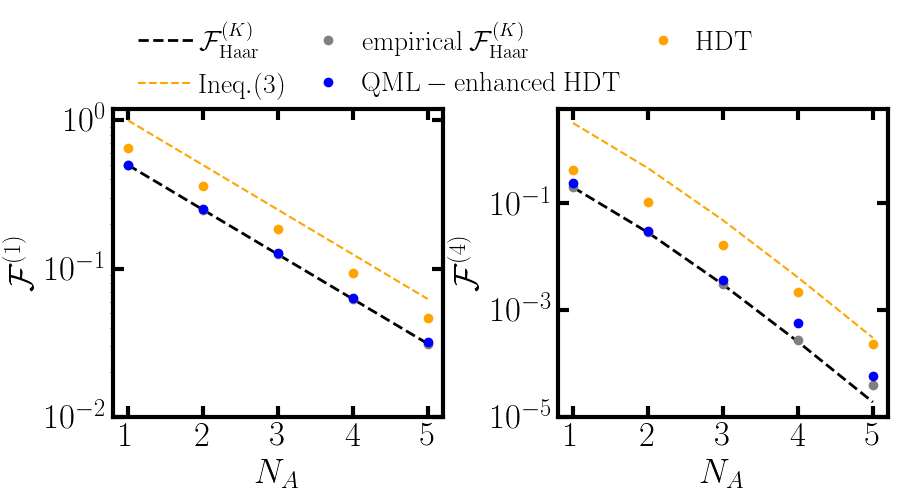

In [ ]:
n = np.arange(1, 6)

fs_qml = np.zeros((4, 5))
fs_rc = np.zeros((4, 5))
fs_haarSample = np.zeros((4, 5))
for i in range(5):
    each = np.load(f'data/training/avgState/n{n[i]}/HaarAvgFP_n{n[i]}na1T{32}L{2*(n[i]+1)}_r0.22.npy')
    fs_qml[:, i] = np.mean(each, axis=1)
    each = np.load(f'data/seqRC/n{n[i]}/HaarUFP_n{n[i]}na1T{32}.npy')
    fs_rc[:, i] = np.mean(each, axis=1)[:4]
    each = np.load(f'data/haarSample/n{n[i]}/HaarSamplesFP_n{n[i]}.npy')
    fs_haarSample[:, i] = np.mean(each, axis=1)[:4]


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i in range(2):
    k = 3*i+1
    fs_haar = 1./binom(k + 2**n - 1, 2**n - 1)
    axs[i].plot(n, fs_haar, '--', c='k', lw=2, label=r'$\mathcal{F}_{\rm Haar}^{(K)}$')
    axs[i].plot(n, (1 + (2**k-1))*fs_haar, '--', c='orange', label=r'$\rm Ineq. (3)$')

    axs[i].plot(n, fs_haarSample[3*i], 'o', c='grey', markersize=6, 
                label=r'${\rm empirical}\: \mathcal{F}_{\rm Haar}^{(K)}$')

    axs[i].plot(n, fs_qml[3*i], 'o', c='b', markersize=6, label=r'$\rm QML-enhanced\:HDT$')
    axs[i].plot(n, fs_rc[3*i], 'o', c='orange', markersize=6, label=r'$\rm HDT$')
    

axs[0].legend(fontsize=20, framealpha=0, loc='lower left', bbox_to_anchor=(0., 0.95), 
    handletextpad=0.2, ncol=3, columnspacing=0.5)
for i in range(2):
    axs[i].set_xticks(n)
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'$\mathcal{F}^{(%d)}$'%(3*i+1))
    axs[i].set_xlabel(r'$N_A$')
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
axs[0].set_yticks([1e-2, 0.1, 1])
axs[1].set_yticks([1e-5, 1e-3, 1e-1])

plt.subplots_adjust(wspace=0.35)
plt.savefig('figures/qml.svg', bbox_inches='tight')
plt.show()
plt.close()


## detail of Q-size

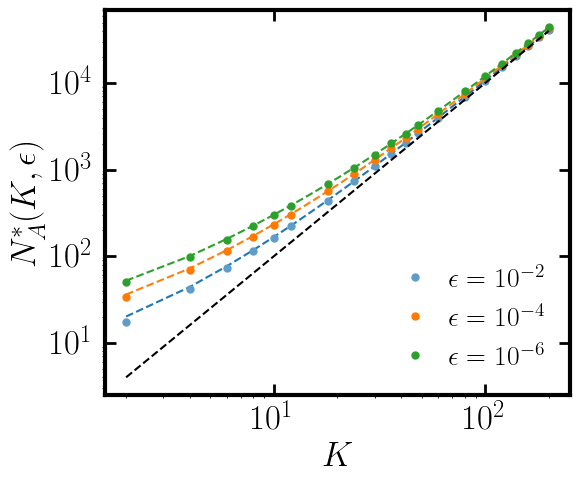

In [ ]:
nc = []
for i in range(3):
    each = np.loadtxt(f'data/seqRC/turningPoint{2*i}.csv')
    nc.append(each)
k = np.hstack((np.arange(2, 52, 2), np.arange(60, 201, 20)))
idx = list(range(5)) + list(range(5, 26, 3)) + list(range(25, 33))

fig, ax = plt.subplots(figsize=(6, 5))
c = ['#5E9DC9', '#FF7903', '#2CA02C']
for i in range(3):
    x = np.log2(10**(2*i+2))
    ax.plot(k, 0.5*(k**2+k*x) + 0.5*np.sqrt((k+x)*(4*x + k**2*(k+x))), '--')
    #ax.plot(k, (k+np.log2(10**(i+2))/2)**2, '--', c=c[i])
    ax.plot(k[idx], nc[i][idx], 'o', c=c[i], markersize=5, 
        label=r'$\epsilon=10^{-%d}$'%(2*i+2))
ax.plot(k, k**2, '--', c='k')
ax.legend(fontsize=20, handletextpad=0.2, framealpha=0, loc='lower right')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$K$')
ax.set_ylabel(r'$N_A^*(K, \epsilon)$')
ax.tick_params(direction='in', right='on', top='on', length=8, width=2, pad=8)

plt.savefig('figures/turningPoint.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
def qVol_minBath(nA, K, eps):
    z = np.log2(1./eps)
    c1 = K * nA - np.log2(factorial(K)) + K + z
    c2 = nA/(K + z) + 1
    c3 = nA + K + z
    return c1*c2*c3

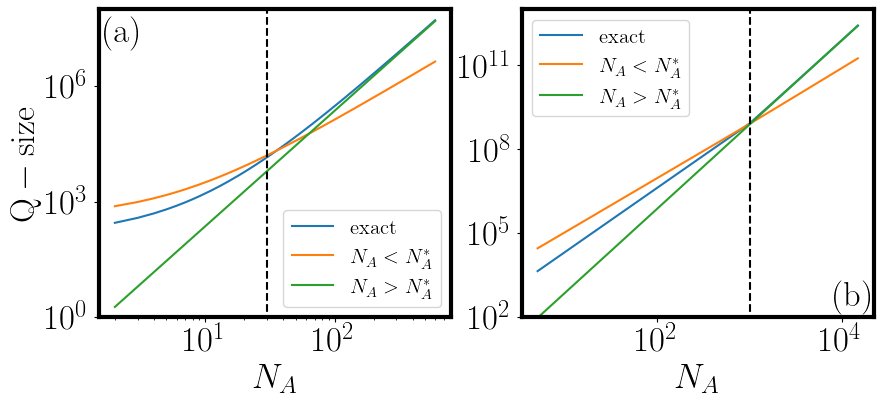

In [ ]:
K1, K2 = 3, 32.
z = np.log2(1./1e-3)
n1, n2 = np.arange(2, round(20*K1*z)), np.arange(5, round(50*K2*z), 1000)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(n1, qVol_minBath(n1, K1, 0.001), label=r'$\rm exact$')
axs[0].plot(n1, (K1+1)*(K1*n1 + z)*(n1 + z), label=r'$N_A < N_A^*$')
axs[0].plot(n1, K1*n1**3/(K1 + z), label=r'$N_A > N_A^*$')
axs[0].vlines(K1*z, ymin=0.1, ymax=2e8, ls='--', color='k')
axs[0].set_ylim(1, 1e8)

axs[1].plot(n2, qVol_minBath(n2, K2, 0.001), label=r'$\rm exact$')
axs[1].plot(n2, (n2 + 1 - np.log2(K2))*K2**3/(K2 + z)*(n2 + K2), label=r'$N_A < N_A^*$')
axs[1].plot(n2, K2*n2**3./(K2 + z), label=r'$N_A > N_A^*$')
axs[1].vlines(K2**2, ymin=10, ymax=2e13, ls='--', color='k')
axs[1].set_ylim(1e2, 1e13)

axs[0].legend(fontsize=15, loc='lower right')
axs[1].legend(fontsize=15, loc='upper left')
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$N_A$')
axs[0].set_ylabel(r'$\rm Q-size$')

fig.text(0.13, 0.8, r'$\rm (a)$')
fig.text(0.86, 0.14, r'$\rm (b)$')

plt.savefig('figures/qVol_minBath.pdf', bbox_inches='tight')
plt.show()
plt.close()

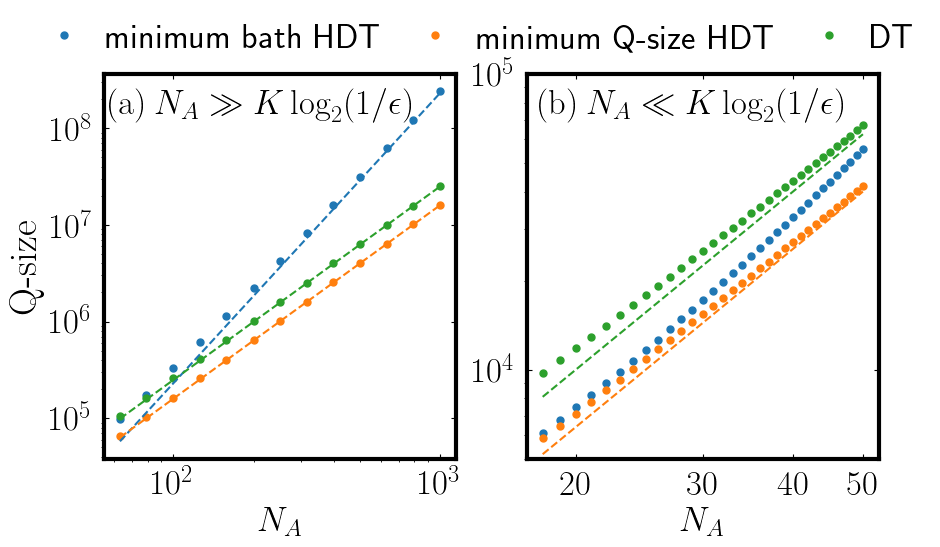

In [ ]:
n1 = np.arange(18, 51)
n2 = np.around(10**np.arange(1.8, 3.1, 0.1))

qVol1 = np.zeros((3, len(n1)))
qVol2 = np.zeros((3, len(n2)))


qVol1[0] = np.loadtxt(f'data/qVol/TminB_K4small.csv')
qVol1[1] = np.loadtxt(f'data/qVol/TminQV_K4small.csv')
qVol1[2] = np.loadtxt(f'data/qVol/NbDT_K4small.csv')

qVol1[0] *= (n1 + 4 + np.log2(1e4))**2
qVol1[1] *= 4*n1**2
qVol1[2] = (n1 + qVol1[2])**2

qVol2[0] = np.loadtxt(f'data/qVol/TminB_K4large.csv')
qVol2[1] = np.loadtxt(f'data/qVol/TminQV_K4large.csv')
qVol2[2] = np.loadtxt(f'data/qVol/NbDT_K4large.csv')

qVol2[0] *= (n2 + 4 + np.log2(1e4))**2
qVol2[1] *= 4*n2**2
qVol2[2] = (n2 + qVol2[2])**2

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 5))
color_cycle = plt.rcParams['axes.prop_cycle']
c = color_cycle.by_key()['color']
label=['minimum bath HDT', 'minimum Q-size HDT', 'DT']
for i in range(3):
    ax1.plot(n1, qVol1[i], 'o', c=c[i], markersize=5, 
                label=label[i])
    ax2.plot(n2, qVol2[i], 'o', c=c[i], markersize=5,
                label=r'$\rm minimum\:bath\:holographic\:DT$')
ax1.plot(n1, 4*4*n1**2, '--', c=c[1])
ax1.plot(n1, (4+1)*n1*((4+1)*n1), '--', c=c[2])

ax2.plot(n2, 4*n2**3/(4 + np.log2(1e4)), '--', c=c[0])
ax2.plot(n2, 4*4*n2**2, '--', c=c[1])
ax2.plot(n2, (4+1)*n2*((4+1)*n2), '--', c=c[2])
ax1.legend(handletextpad=0.2, loc='lower left', bbox_to_anchor=(-1.5, 0.97),
    framealpha=0, ncol=3, columnspacing=0.5)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax2.set_ylabel(r'$\rm Q$'+'-'+r'$\rm size$', fontsize=28)
ax1.tick_params(direction='in', right='on', top='on', pad=8)
ax2.tick_params(direction='in', right='on', top='on', pad=8)
ax1.set_xticks([20, 30, 40, 50])
ax1.set_xticklabels([r'$20$', r'$30$', r'$40$', r'$50$'])
ax1.set_ylim(5e3, 1e5)
ax1.set_xlabel(r'$N_A$')
ax2.set_xlabel(r'$N_A$')

plt.subplots_adjust(wspace=0.2)

fig.text(0.13, 0.8, r'${\rm (a)}\:N_A \gg K\log_2(1/\epsilon)$')
fig.text(0.56, 0.8, r'${\rm (b)}\:N_A \ll K\log_2(1/\epsilon)$')

plt.savefig('figures/qVol_addition.pdf', bbox_inches='tight')
plt.show()
plt.close()

## detail of frame potential

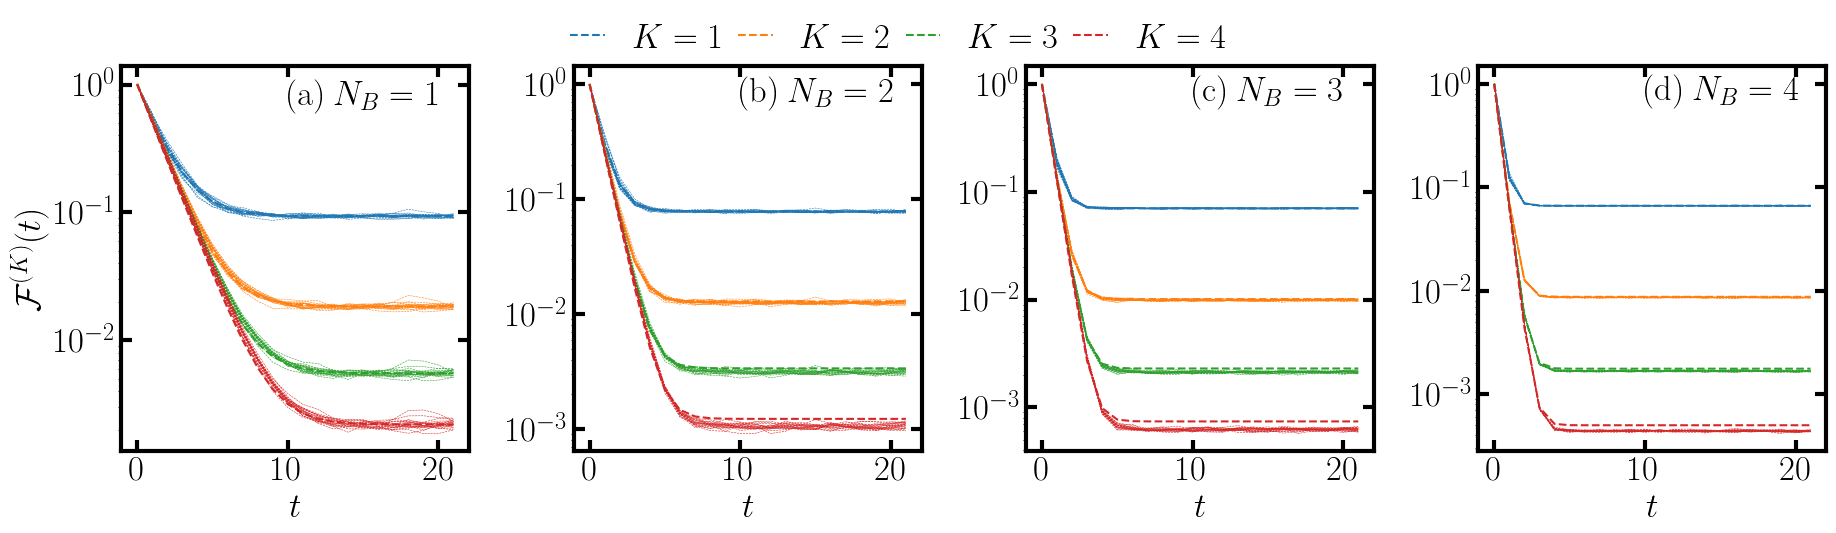

In [11]:
nb = np.arange(1, 5)
fs_traj = np.zeros((4, 4, 20, 33))
for i in range(4):
    fs_traj[i]  = np.load(f'data/seqRC/n{4}/HaarUFPtraj_n{4}na{nb[i]}T{32}.npy')

fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True)
color_cycle = plt.rcParams['axes.prop_cycle']
c = color_cycle.by_key()['color']

for i in range(4):
    for k in range(4):
        axs[i].plot(range(22), fs_traj[i, k, :, :22].T, '--', c=c[k], lw=0.4)
        if not k:
            axs[i].plot(FP1evo(16, 2**nb[i], np.arange(22)), '--', c=c[k], label=fr'$K={k+1}$')
        else:
            F_th = (2.**nb[i])**(-np.arange(22)) + (1 + (2**(k+1)-1)/2**nb[i])/binom(k+1+16-1,16-1)
            axs[i].plot(F_th, '--', c=c[k], label=fr'$K={k+1}$')
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$t$')
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
    axs[i].text(10, 0.7, fr'$(\rm {chr(97+i)})$' + fr'$\: N_B={nb[i]}$')
axs[0].legend(ncol=4, columnspacing=0.4, handlelength=1, loc='lower left', bbox_to_anchor=(1.2, 0.95), 
    framealpha=0)
axs[0].set_ylabel(r'$\mathcal{F}^{(K)}(t)$')

plt.subplots_adjust(wspace=0.3)
plt.savefig('figures/Fevo_addition.pdf', bbox_inches='tight')
plt.show()
plt.close()


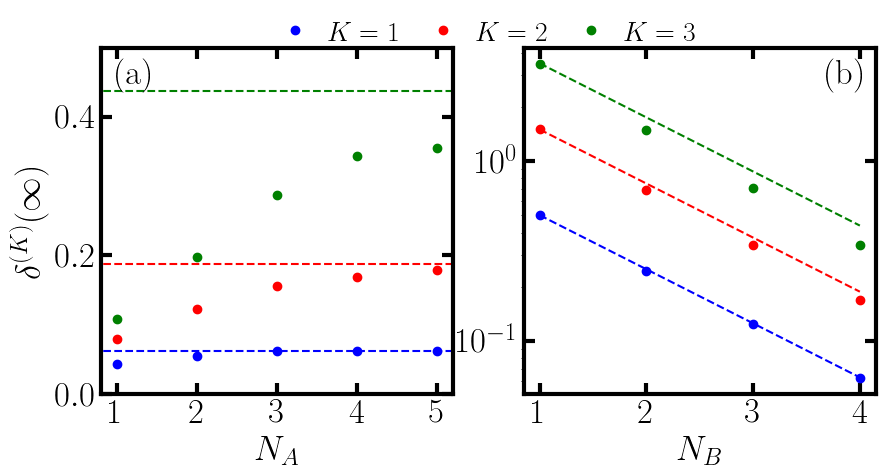

In [10]:
n = np.arange(1, 6)
fs = np.zeros((3, 5))
fs_sample = np.zeros((3, 5))
for i in range(5):
    each = np.load(f'data/seqRC/n{n[i]}/HaarUFP_n{n[i]}na{4}T{32}.npy')
    fs[:, i] = np.mean(each, axis=1)[:3]
    each = np.load(f'data/haarSample/n{n[i]}/HaarSamplesFP_n{n[i]}.npy')
    fs_sample[:, i] = np.mean(each, axis=1)[:3]

fs2 = np.zeros((3, 4))
nb = np.arange(1, 5)
for i in range(4):
    each = np.load(f'data/seqRC/n{4}/HaarUFP_n{4}na{nb[i]}T{32}.npy')
    fs2[:, i] = np.mean(each, axis=1)[:3]

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
c = ['b', 'r', 'g', 'orange']
for i in range(3):
    axs[0].plot(n, fs[i]/fs_sample[i]-1, 'o', c=c[i], label=fr'$K={i+1}$')
    axs[0].hlines((2**(i+1)-1)/2**4, xmin=0, xmax=6, ls='--', color=c[i])

    axs[1].plot(nb, fs2[i]/fs_sample[i, 3]-1, 'o', c=c[i])
    axs[1].plot(nb, (2**(i+1) - 1)/2**nb, '--', color=c[i])
axs[0].legend(fontsize=20, framealpha=0, handletextpad=0.2, ncol=3, columnspacing=0.5,
    loc='upper left', bbox_to_anchor=(0.4, 1.15))
axs[1].set_yscale('log')
axs[0].set_ylim(0, 0.5)
axs[0].set_xlim(0.8, 5.2)
axs[0].set_ylabel(r'$\delta^{(K)}(\infty)$')
axs[0].set_xlabel(r'$N_A$')
axs[1].set_xlabel(r'$N_B$')
axs[0].set_xticks(n)
axs[1].set_xticks(nb)
for i in range(2):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')

fig.text(0.14, 0.8, r'$\rm (a)$')
fig.text(0.85, 0.8, r'$\rm (b)$')

plt.savefig('figures/F_inf.pdf', bbox_inches='tight')
plt.show()
plt.close()

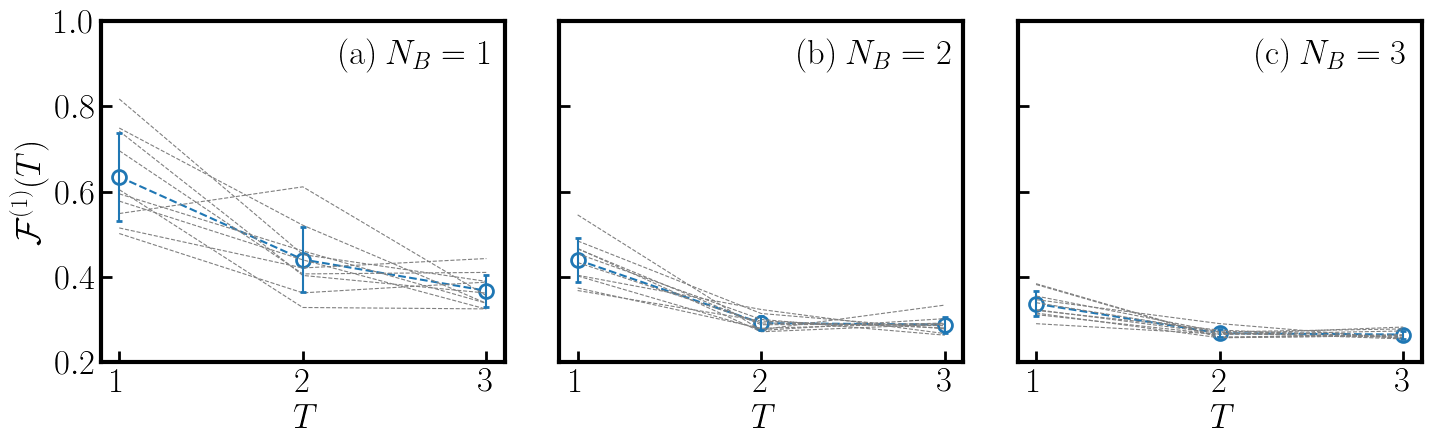

In [ ]:
f = np.load(f'data/experiment/purity/brisbane/Tradeoff_Brisbane_sep.npy')

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i in range(3):
    axs[i].plot(range(1, 4), f[i], '--', c='grey', lw=0.8)
    axs[i].errorbar(range(1, 4), f[i].mean(1), yerr=f[i].std(1), barsabove=True,
        fmt='o--', mfc='white', capsize=2, markersize=10, markeredgewidth=2)
    axs[i].set_xlabel(r'$T$')
    axs[i].tick_params(direction='in', length=8, width=2)
    axs[i].text(2.2, 0.9, fr'$(\rm {chr(97+i)})$' + fr'$\:N_B={i+1}$')
axs[0].set_ylabel(r'$\mathcal{F}^{(1)}(T)$')
axs[0].set_ylim(0.2, 1)

plt.tight_layout()

plt.savefig('figures/tradeoff_detail.pdf', bbox_inches='tight')
plt.show()
plt.close()